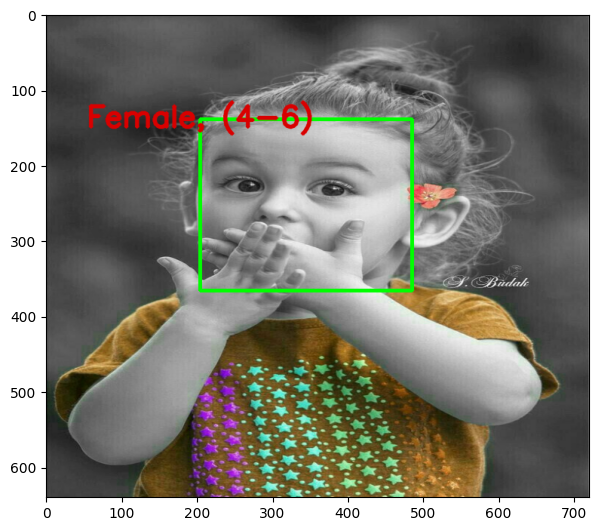

In [3]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('image3.jpg')
image = cv2.resize(image, (720, 640))
# Importing Models and set mean values
face1 = "opencv_face_detector.pbtxt"
face2 = "opencv_face_detector_uint8.pb"
age1 = "age_deploy.prototxt"
age2 = "age_net.caffemodel"
gen1 = "gender_deploy.prototxt"
gen2 = "gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

face = cv2.dnn.readNet(face2, face1)

age = cv2.dnn.readNet(age2, age1)

gen = cv2.dnn.readNet(gen2, gen1)
# Categories of distribution
la = ['(0-2)', '(4-6)', '(8-12)', '(15-20)',
	'(25-32)', '(38-43)', '(48-53)', '(60-100)']
lg = ['Male', 'Female']
# Copy image
fr_cv = image.copy()
# Face detection
fr_h = fr_cv.shape[0]
fr_w = fr_cv.shape[1]
blob = cv2.dnn.blobFromImage(fr_cv, 1.0, (300, 300),
							[104, 117, 123], True, False)

face.setInput(blob)
detections = face.forward()
# Face bounding box creation
faceBoxes = []
for i in range(detections.shape[2]):
	
	#Bounding box creation if confidence > 0.7
	confidence = detections[0, 0, i, 2]
	if confidence > 0.7:
		
		x1 = int(detections[0, 0, i, 3]*fr_w)
		y1 = int(detections[0, 0, i, 4]*fr_h)
		x2 = int(detections[0, 0, i, 5]*fr_w)
		y2 = int(detections[0, 0, i, 6]*fr_h)
		
		faceBoxes.append([x1, y1, x2, y2])
		
		cv2.rectangle(fr_cv, (x1, y1), (x2, y2),
					(0, 255, 0), int(round(fr_h/150)), 8)
		
# Checking if face detected or not
if not faceBoxes:
	print("No face detected")

# Final results (otherwise)
# Loop for all the faces detected
for faceBox in faceBoxes:
	
	#Extracting face as per the faceBox
	face = fr_cv[max(0, faceBox[1]-15):
				min(faceBox[3]+15, fr_cv.shape[0]-1),
				max(0, faceBox[0]-15):min(faceBox[2]+15,
							fr_cv.shape[1]-1)]
	
	#Extracting the main blob part
	blob = cv2.dnn.blobFromImage(
		face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
	
	#Prediction of gender
	gen.setInput(blob)
	genderPreds = gen.forward()
	gender = lg[genderPreds[0].argmax()]
	
	#Prediction of age
	age.setInput(blob)
	agePreds = age.forward()
	age = la[agePreds[0].argmax()]
	
	#Putting text of age and gender
	#At the top of box
	cv2.putText(fr_cv,
				f'{gender}, {age}',
				(faceBox[0]-150, faceBox[1]+10),
				cv2.FONT_HERSHEY_SIMPLEX,
				1.3,
				(217, 0, 0),
				4,
				cv2.LINE_AA)

	plt.figure(figsize=(7, 7))
	plt.imshow(fr_cv)
